# Homework 1 - Information Retrieval 2018
### Florian Mohnert, Mario Giulianelli, Akash Raj

In [1]:
import copy
import itertools
import random

from collections import defaultdict
from IPython.display import Image
from math import log
from matplotlib import pyplot as plt
from pprint import pprint
from scipy.stats import binom_test

import numpy as np

## Theoretical Part

##### Hypothesis Testing: the problem of multiple comparisons 

Given that:
- $\alpha$ is the Type I error for each test
- $\beta$ is the Type II error
- $1 - \beta$ is the power

a) P($m^{th}$ experiment gives significant result | $m$ experiments lacking power to reject $H_0$) = $\alpha (1 - \beta)^{m-1}$,

where $(1 - \beta)^{m-1}$ is the probability that the first $m - 1$ experiments correctly conclude that the result is not significant, and $\alpha$ is the probability that the next experiment will yield a Type I error. We can rephrase this event as
> Experiment 1 correctly rejects $H_0$ **AND** Experiment 2 correctly rejects $H_0$ **AND ... AND** Experiment $m$ yields a Type I error.

b) P(at least one significant result | $m$ experiments lacking power to reject $H_0$) = $m \alpha$. 

We can rephrase this event as 
> Experiment 1 yields a Type I error **OR** Experiment 2 yields a Type I error **OR ... OR** Experiment $m$ yields a Type I error.

which can be translated into an $m$-fold addition of the Type I error probability $\alpha$.

##### Bias and unfairness in Interleaving experiments

We present a situation where interleaving should produce a preference for one of the two ranking lists but 
it fails to do so and it assigns equal expected winning probability to both rankings.

Let $d_3$ be the only relevant document, i.e. the only document the user will click on.
In list A, $d_3$ is ranked as third, whereas $d_3$ is in the second position of Ranking A. Therefore, Ranking B is expected to win more often than Ranking B. Consider, however, the following rankings and the four lists that can be generated using Team Draft Interleaving:

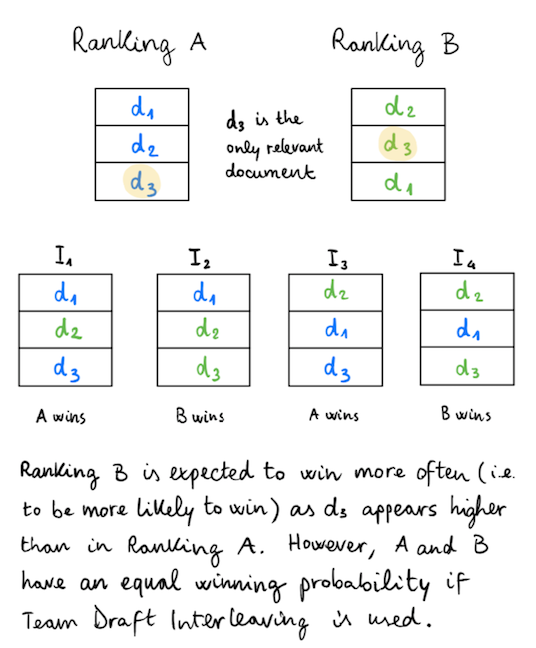

In [2]:
Image("interleaving_bias.png")

## Practical Part

### Simulate Rankings of Relevance for E and P

In [3]:
relevance = [0, 1, 2]  # 0: N, 1: R, 2: HR
combinations = list(itertools.product(relevance, repeat=5))
ranking_pairs = list(itertools.product(combinations, repeat=2))

# delete ratings that are the same for both P and E
for i, pair in enumerate(ranking_pairs):
    if pair[0] == pair[1]:
        del ranking_pairs[i]
        
        
#### Create biased samples ####

split = int(len(ranking_pairs) / 2)
idx_e = np.random.choice(split, 7000)  # second table
idx_p = np.random.choice(split, 3000)
# idx_e = np.random.choice(split, 9000)  # third table
# idx_p = np.random.choice(split, 1000)

biased_sample_e = []
biased_sample_p = []

for i in idx_e:
    biased_sample_e.append(ranking_pairs[i])
    
for i in idx_p:
    biased_sample_p.append(ranking_pairs[i])
    
idx_e = np.random.choice(np.arange(split, len(ranking_pairs)), 3000)  # second table
idx_p = np.random.choice(np.arange(split, len(ranking_pairs)), 7000)
# idx_e = np.random.choice(np.arange(split, len(ranking_pairs)), 1000)  # third table
# idx_p = np.random.choice(np.arange(split, len(ranking_pairs)), 9000)

for i in idx_e:
    biased_sample_e.append(ranking_pairs[i])
    
for i in idx_p:
    biased_sample_p.append(ranking_pairs[i])
    

### Implement 1 binary and 2 multi-graded evaluation measures

In [4]:
def average_precision(query_judgement, tot_relevant_docs):
    l = []
    rel_docs = 0
    
    for i, judgement in enumerate(query_judgement, start=1):
        if judgement != 0:
            rel_docs += 1
            l.append(rel_docs / i)
    
    return sum(l) / tot_relevant_docs       

In [5]:
def DCG(query_judgement, k):
    query_judgement = list(query_judgement)[:k]
    dcg = 0
    
    for i, judgement in enumerate(query_judgement, start=1):
        dcg += (2 ** judgement - 1) / log(i + 1, 2)
        
    return dcg

def NDCG(query_judgement, k):
    perfect_ordering = sorted(query_judgement, reverse=True)
    perfect_score = DCG(perfect_ordering, k)
    
    if perfect_score == 0:
        return 0
    
    return DCG(query_judgement, k) / perfect_score

In [6]:
max_rel = 2  # ad-hoc for 3 different judgements
satisfaction_probs = [(2 ** rel - 1) / 2 ** max_rel for rel in range(3)]

def ERR(query_judgement):
    sat_probs = []
    
    for rel in query_judgement:
        sat_probs.append(satisfaction_probs[rel])
        
    err = 0
    prod = 1
    
    for i in range(1, len(query_judgement) + 1):
        rel_prob = sat_probs[i - 1]
        
        err += prod * rel_prob / i
        prod *= 1 - rel_prob
    
    return err


### Calculate the $\Delta$measure
$\Delta measure = measure_e - measure_p$.
Here, as required, we consider only those pairs for which E outperforms P.

In [7]:
tot_rel_docs = 10
positive_AP_differences = []
positive_NDCG_differences = []
positive_ERR_differences = []

for p, e in ranking_pairs:
    delta_AP = average_precision(e, tot_rel_docs) - average_precision(p, tot_rel_docs)
    if delta_AP > 0:
        positive_AP_differences.append(delta_AP)
    
    delta_NDCG = NDCG(e, 5) - NDCG(p, 5)
    if delta_NDCG > 0:
        positive_NDCG_differences.append(delta_NDCG) 
    
    delta_ERR = ERR(e) - ERR(p)
    if delta_ERR > 0:
        positive_ERR_differences.append(delta_ERR)
    
positive_AP_differences = np.array(positive_AP_differences)
positive_NDCG_differences = np.array(positive_NDCG_differences)
positive_ERR_differences = np.array(positive_ERR_differences)
    

In [8]:
print('           mean          variance', )
print('AP   ', positive_AP_differences.mean(), positive_AP_differences.var())
print('NDCG ', positive_NDCG_differences.mean(), positive_NDCG_differences.var())
print('ERR  ', positive_ERR_differences.mean(), positive_ERR_differences.var())

           mean          variance
AP    0.160399108058 0.0115550462886
NDCG  0.189101356671 0.0204009107147
ERR   0.266784146336 0.0391920532749


### Team Draft Interleaving

In [9]:
def team_draft_interleaving(list_a, list_b):
    '''
    Implementation of the team draft interleaving algorithm
    Args:
        a, b: list
    Return:
        interleaved_list, chosen_list
    '''
    final_list = []
    chosen = []  # list containing a/b values

    # This is done so that original lists are not modified
    a = copy.deepcopy(list_a)
    b = copy.deepcopy(list_b)

    idx_a = 0
    idx_b = 0
    
    while (len(a) > 0 and len(b) > 0):
        choose_a = bool(random.getrandbits(1))

        if choose_a:
            current_a = a.pop(0)
            final_list.append(current_a)
            chosen.append('a')

            if current_a in b: 
                b.remove(current_a)
            
            if len(b) <= 0:
                break
            
            current_b = b.pop(0)
            final_list.append(current_b)
            chosen.append('b')
            
            if current_b in a:
                a.remove(current_b)
        else:
            current_b = b.pop(0)
            final_list.append(current_b)
            chosen.append('b')

            if current_b in a: 
                a.remove(current_b)

            if len(a) <= 0:
                break
                
            current_a = a.pop(0)
            final_list.append(current_a)
            chosen.append('a')
            
            if current_a in b:
                b.remove(current_a)

    return final_list, chosen

In [10]:
def team_draft_credit(pointer_list, simulated_clicks):
    
    credit_a, credit_b = 0, 0
    
    for i, click in enumerate(simulated_clicks):
        if click:
            credit_a += pointer_list[i] == 'a'
            credit_b += pointer_list[i] == 'b'
    
    return credit_a, credit_b

In [11]:
### Test ###

a = [1, 2, 3, 4, 7, 8]
b = [2, 5, 1, 6, 7, 8]

interleaved, pointers = team_draft_interleaving(a, b)
clicks = random.sample(range(len(a)), 3)

print('-'*51)
print('interleaved  :', interleaved)
print('pointers     :', pointers)
print('clicks       :', clicks, ' {NOTE: indices start from 0}')
print('credit (a, b):', team_draft_credit(pointers, clicks))
print('-'*51)

---------------------------------------------------
interleaved  : [1, 2, 3, 5, 6, 4, 7, 8]
pointers     : ['a', 'b', 'a', 'b', 'b', 'a', 'a', 'b']
clicks       : [5, 4, 3]  {NOTE: indices start from 0}
credit (a, b): (2, 1)
---------------------------------------------------


### User Clicks Simulation

In [12]:
# Read in data
data = []

with open("YandexRelPredChallenge.txt","r") as yandex:
    for line in yandex:
        data.append(line.strip().split('\t'))
        

In [13]:
class Session():
    '''
    A Session consists of a single query q, the corresponding
    list of retrieved documents, and the clicks occurred after
    the q and before the next query q'.
    '''
    def __init__(self, queryID, doc_list):
        self.id = queryID
        self.doc_list = doc_list
        self.clicks = []
        
    def add_click(self, docID):
        if docID not in [idx for (idx, _) in self.clicks]:
            try:
                # ranks start from 0
                rank = self.doc_list.index(docID)
                self.clicks.append((docID, rank))
            except ValueError:
                # Click occurred on a doc that is not in retrieved doc list
                pass


In [14]:
def read_sessions(filepath):
    '''
    Reads YandexRelPredChallenge and returns a list of all Session 
    objects corresponding to the search sessions in the file.
    '''
    sessions = []
    
    log = []
    with open(filepath, 'r') as log_file:
        for line in log_file:
            line = line.strip().split('\t')
            log.append(line)
        
    # Initialization step. (Assumption: 0th index in log contains a query)
    current_session = Session(int(log[0][3]), list(map(int, log[0][5:])))
    i = 1

    while i < len(log):
        if log[i][2] == 'C':
            while (i < len(log)) and log[i][2] == 'C':
                docID = int(log[i][3])
                current_session.add_click(docID)
                i += 1
        else:
            while (i < len(log)) and log[i][2] == 'Q':
                sessions.append(copy.deepcopy(current_session))

                queryID = int(log[i][3])
                doc_list = list(map(int, log[i][5:]))
                current_session = Session(queryID, doc_list)

                i += 1
                
    # last session is not saved in the while loop
    sessions.append(copy.deepcopy(current_session))

    return sessions


In [15]:
sessions = read_sessions("YandexRelPredChallenge.txt")

# Helper dictionary for performance
query_to_sessions = {}

for sess in sessions:
    idx = sess.id
    
    if idx in query_to_sessions.keys():
        query_to_sessions[idx].append(sess)
    else:
        query_to_sessions[idx] = [sess]

### Random Click Model: parameter estimation and prediction

In [16]:
# Random click model: param and prediction

def rcm_param(data):
    clicks = 0
    number_docs_shown = 0
    for line in data:
        if line[2] == "C":
            clicks += 1
        if line[2] == "Q":
            number_docs_shown += len(line[5:])
        
    return clicks / number_docs_shown


def rcm_predict(ranked_list, p):
    clicks = []
    for entries in ranked_list:
        click = np.random.binomial(1,p)
        clicks.append(click)
        
    return clicks
            

### Position Based Model: parameter estimation (EM) and prediction

In [17]:
def EM(sessions, S, query_to_sessions, iterations):
    k = 10  # number of ranks considered
    examination = [0.05] * 10 # length 10
    attractiveness = defaultdict(lambda: 0.5)  # (docID, queryID) -> alpha_uq
    
    list_of_sums_alpha = []
    list_of_sums_epsi = []
    
    for i in range(iterations):
        if i % 5 == 0 and i != 0:
            print('iteration', i)
            
        attractiveness_prev = copy.deepcopy(attractiveness)
        
        for (docID, queryID) in S.keys():
            sum_ = 0
            
            for sess in query_to_sessions[queryID]:
                found = False
                for idx, _ in sess.clicks:
                    if idx == docID:
                        sum_ += 1
                        found = True
                        break
                
                if not found:
                    try:
                        rank = sess.doc_list.index(docID)
                        sum_ += ((1 - examination[rank]) * attractiveness_prev[(docID, queryID)]) \
                                / (1 - examination[rank] * attractiveness_prev[(docID, queryID)]) 
                    except:
                        pass
            
            attractiveness[(docID, queryID)] = sum_ / S[(docID, queryID)]
        
        for r in range(k):
            sum_ = 0
            for sess in sessions:
                doc_at_r = sess.doc_list[r]
                query_id = sess.id
                
                if doc_at_r in [idx for (idx, _) in sess.clicks]:
                    sum_ += 1
                else:
                    sum_ += ((1 - attractiveness_prev[(doc_at_r, query_id)]) * examination[r]) \
                            / (1 - examination[r] * attractiveness_prev[(doc_at_r, query_id)]) 
                    
            examination[r] = sum_ / len(sessions)
        
        list_of_sums_alpha.append(sum(list(attractiveness.values())))
        list_of_sums_epsi.append(sum(examination))

    return attractiveness, examination, list_of_sums_alpha, list_of_sums_epsi
        

In [18]:
def estimate_PBM(sessions):
    S = defaultdict(int)
    
    for sess in sessions:
        queryID = sess.id
        for docID in sess.doc_list:
            S[(docID, queryID)] += 1
    
    return S


In [19]:
def predict_PBM(interleaved_list, examination):
    attractiveness = [(2 ** rel - 1) / 2 ** max_rel for rel in range(3)]
    
    clicks = []
    for r, doc_id in enumerate(interleaved_list):
        click_prob = attractiveness[doc_id] * examination[r]
        clicks.append(np.random.binomial(1, click_prob))
        
    return clicks
  

In [20]:
prob = rcm_param(data)

S = estimate_PBM(sessions)
iterations = 30
alpha, epsi, alpha_sums, epsi_sums = EM(sessions, S, query_to_sessions, iterations=iterations)

iteration 5
iteration 10
iteration 15
iteration 20
iteration 25


### Simulate Interleaving Experiment

In [21]:
def simulate_interleaving(ranking_pairs, n, param, model='rcm'):
    result_list = []
    results_all = []
    for (p, e) in ranking_pairs:
        wins_e = 0
        wins_p = 0
        ties = 0
        
        for simulation in range(n):
            
            i_list, pointer_list = team_draft_interleaving(list(p), list(e))
            if model.lower() == 'rcm':
                clicks = rcm_predict(i_list, param)  # one-hot
            elif model.lower() == 'pbm':
                clicks = predict_PBM(i_list, param)  # one-hot
            else:
                raise Exception("Only 'rcm' or 'pbm' are allowed.")
                
            credit_p, credit_e = team_draft_credit(pointer_list, clicks)

            if credit_e > credit_p:
                wins_e += 1
            if credit_e < credit_p:
                wins_p += 1
            if credit_e == credit_p:
                ties += 1
        
        results = [wins_e, wins_p, ties]
        results_all.append([x/n for x in results])
        result_list.append(results.index(max(results)))
        
    return result_list, results_all

In [22]:
result_list_rcm, results_rcm = simulate_interleaving(ranking_pairs, 10, prob, 'rcm')
result_list_rcm = np.array(result_list_rcm)
results_rcm = np.array(results_rcm)

result_list_pbm, results_pbm = simulate_interleaving(ranking_pairs, 10, epsi, 'pbm')
result_list_pbm = np.array(result_list_pbm)
results_pbm = np.array(results_pbm)

In [23]:
def delta_measure(ranking_pairs):
    tot_rel_docs = 10
    ndcg_k = 5
    
    AP_differences = []
    NDCG_differences = []
    ERR_differences = []

    for p, e in ranking_pairs:
        delta_AP = average_precision(e, tot_rel_docs) - average_precision(p, tot_rel_docs)
        AP_differences.append(delta_AP)

        delta_NDCG = NDCG(e, ndcg_k) - NDCG(p, ndcg_k)
        NDCG_differences.append(delta_NDCG) 

        delta_ERR = ERR(e) - ERR(p)
        ERR_differences.append(delta_ERR)

    AP_differences = np.array(AP_differences)
    NDCG_differences = np.array(NDCG_differences)
    ERR_differences = np.array(ERR_differences)
    
    return AP_differences, NDCG_differences, ERR_differences

In [24]:
# Compute deltas
ap_diffs, ndcg_diffs, err_diffs = delta_measure(ranking_pairs)

In [25]:
def sign_test(differences, num_pairs):
    ''' 
    Implementation of sign test
    Args:
        differences:  # of differences where p>e 
        num_pairs: number of pairs in total
    Return:
        p-value
    '''
    return binom_test(differences, num_pairs, 0.5, alternative='greater')

### How often do offline and online measure agree?

In [26]:
def count_overlaps(result_list, diff_list):
    n_overlaps = 0
    
    for i in range(len(result_list)):
        if diff_list[i] > 0 and result_list[i] == 0:
            n_overlaps += 1
        elif diff_list[i] < 0 and result_list[i] == 1:
            n_overlaps += 1
        elif diff_list[i] == 0 and result_list[i] == 2:
            n_overlaps += 1
            
    return n_overlaps

#### Normalized Discounted Cumulative Gain (NDCG@5) vs RCM/PBM + Team-Draft Interleaving

In [27]:
num_e_greater_than_p_ndcg = len([d for d in ndcg_diffs if d > 0])
num_p_greater_than_e_ndcg = len([d for d in ndcg_diffs if d < 0])
num_p_equals_e_ndcg = len([d for d in ndcg_diffs if d == 0])

prop_e_ndcg = num_e_greater_than_p_ndcg / len(ndcg_diffs)
prop_p_ndcg = num_p_greater_than_e_ndcg / len(ndcg_diffs)
prop_ties_ndcg = num_p_equals_e_ndcg / len(ndcg_diffs)

# print(sign_test(num_e_greater_than_p_ndcg, len(ndcg_diffs)))
# print(sign_test(num_p_greater_than_e_ndcg, len(ndcg_diffs)))
        
n_overlaps_ndcg_rcm = count_overlaps(result_list_rcm, ndcg_diffs)
n_overlaps_ndcg_pbm = count_overlaps(result_list_pbm, ndcg_diffs)

#### MAP vs RCM/PBM + Team-Draft Interleaving

In [28]:
num_e_greater_than_p_ap = len([d for d in ap_diffs if d > 0])
num_p_greater_than_e_ap = len([d for d in ap_diffs if d < 0])
num_p_equals_e_ap = len([d for d in ap_diffs if d == 0])

# print(sign_test(num_e_greater_than_p_ap, len(ap_diffs)))
# print(sign_test(num_p_greater_than_e_ap, len(ap_diffs)))

prop_e_ap = num_e_greater_than_p_ap / len(ap_diffs)
prop_p_ap = num_p_greater_than_e_ap / len(ap_diffs)
prop_ties_ap = num_p_equals_e_ap / len(ap_diffs)

n_overlaps_ap_rcm = count_overlaps(result_list_rcm, ap_diffs)
n_overlaps_ap_pbm = count_overlaps(result_list_pbm, ap_diffs)

#### Expected Reciprocal Rank vs RCM/PBM + Team-Draft Interleaving

In [29]:
num_e_greater_than_p_err = len([d for d in err_diffs if d > 0])
num_p_greater_than_e_err = len([d for d in err_diffs if d < 0])
num_p_equals_e_err = len([d for d in err_diffs if d == 0])

prop_e_err = num_e_greater_than_p_err / len(err_diffs)
prop_p_err = num_p_greater_than_e_err / len(err_diffs)
prop_ties_err = num_p_equals_e_err / len(err_diffs)

# print(sign_test(num_e_greater_than_p_err, len(err_diffs)))
# print(sign_test(num_p_greater_than_e_err, len(err_diffs)))

n_overlaps_err_rcm = count_overlaps(result_list_rcm, err_diffs)
n_overlaps_err_pbm = count_overlaps(result_list_pbm, err_diffs)

### Click models: proportions of wins and ties

In [30]:
wins_p_rcm = 0
wins_e_rcm = 0

for indicator in result_list_rcm:
    if indicator == 0:
        wins_e_rcm += 1
    elif indicator == 1:
        wins_p_rcm += 1

wins_p_pbm = 0
wins_e_pbm = 0

for indicator in result_list_pbm:
    if indicator == 0:
        wins_e_pbm += 1
    elif indicator == 1:
        wins_p_pbm += 1

prop_e_rcm = wins_e_rcm / len(results_rcm)
prop_p_rcm = wins_p_rcm / len(results_rcm)
prop_ties_rcm = 1 - (prop_e_rcm + prop_p_rcm)

prop_p_pbm = wins_p_pbm / len(results_pbm)
prop_e_pbm = wins_e_pbm / len(results_pbm)
prop_ties_pbm = 1 - (prop_e_pbm + prop_p_pbm)


In [31]:
### Utility function ###
def print_results(list1, list2):
    assert len(list1) == 6
    assert len(list2) == 15
    
    to_print_1 = "\n \
                  |                  |RCM + Interleaving  |PBM  + Interleaving  |\n \
                  |------------------|:------------------:|:-------------------:|\n \
                  |Average Precision |{}                |{}                |\n \
                  |NDCG              |{}                |{}                |\n \
                  |ERR               |{}                |{}                |\n".format(*list1)

    to_print_2 = "\n \
                 |                  |Wins P              | Wins E               | Ties  |\n \
                 |------------------|:------------------:|:--------------------:|:-----:|\n \
                 |Average Precision |{}               |{}                 |{}  |\n \
                 |NDCG              |{}               |{}                 |{}  |\n \
                 |ERR               |{}               |{}                 |{}  |\n \
                 |RCM + Interleaving|{}               |{}                 |{}  |\n \
                 |PBM + Interleaving|{}               |{}                 |{}  |\n".format(*list2)
    
    print(to_print_1)
    print(to_print_2)

In [32]:
list1 = [round(x, 3) for x in [n_overlaps_ap_rcm, n_overlaps_ap_pbm,
                               n_overlaps_ndcg_rcm, n_overlaps_ndcg_pbm,
                               n_overlaps_err_rcm, n_overlaps_err_pbm]]

list2 = [round(x, 3) for x in [prop_p_ap, prop_e_ap, prop_ties_ap,
                               prop_p_ndcg, prop_e_ndcg, prop_ties_ndcg,
                               prop_p_err, prop_e_err, prop_ties_err,
                               prop_p_rcm, prop_e_rcm, prop_ties_rcm,
                               prop_p_pbm, prop_e_pbm, prop_ties_pbm]]
# print_results(list1, list2)

## Results and Analysis

The performance of the production ranking algorithm P and of the experimental algorithm E were analysed by computing offline and online measures on every pair of SERPs retrieved by P and E. The following offline measures were considered in our study: Average Precision, Normalized Discounted Cumulative Gain and Expected Reciprocal Rank; as well as two online measures: Team-Draft Interleaving with click simulations based on the Random Click Model and the Position Based Model.

### Assumptions for offline measures
In order to measure Average Precision, we assumed that the relevance labels "HR" and "R" both correspond to a relevant document, hence we transformed labels from ternary (and graded) to binary. Additionally, we postulate that the number of relevant documents in the collection be 10. This choice is motivated by the fact that, if E and P jointly return 10 unique documents for a given query, then there must exist at least 10 relevant documents in the collection. Finally, NDCG was computed up to rank 5 because SERPs are always of length 5 in our simulation. 

### Click models and Team-Draft Interleaving
We implemented the Team-Draft Interleaving method to merge the ranked lists produced by P and E. Then, we applied the Random Click Model (RCM) and the Position Based Model (PBM) to simulate user click behavior and assign credits to the two algorithms under scrutiny.

### Training the models
##### Data
The Yandex log data was used to train the two click models. In order to simplify the estimation procedure, we worked under the assumption that a session consists of a single query q, the documents retrieved for q, and the clicks that follow q and precede the next query q'. Another preprocessing step was the removal of duplicate clicks within a session. 

##### Parameter estimation
The RMC has a single parameter, which was estimated using Maximum Likelihood Estimation. The PBM, on the other hand, requires the Expectation Maximization algorithm as parameters are interdependent and the attractiveness parameter is unobserved. EM was run for 30 iterations, that is until attractiveness values converged to a stable solution. Both attractiveness and examination probabilities were estimated but the former were discarded at prediction time and replaced with a function of the relevance labels ($rel$) of each retrieved document: 

$$\frac{2^{rel_{i}}-1}{2^{max(rel)}}$$


### Comparing Offline and Online Evaluation Measures

As a first step, we evaluated the sensitivity of offline and online measures with a small case study. We constructed two biased samples, each consisting of 10000 ranking pairs, with different degrees of bias towards the experimental search engine. We expected all measures to detect the magnitude of bias in the samples. The first table below shows the results for an unbiased sample. The subsequent tables report the results of the more and more biased samples. 

|                  |P: proportion of wins              | E: proportion of wins               | Ties  |
                  |------------------|:------------------:|:--------------------:|:-----:|
                  |Average Precision |0.475               |0.475                 |0.049  |
                  |NDCG@5             |0.496               |0.496                 |0.007  |
                  |ERR               |0.499               |0.499                 |0.001  |
                  |RCM + Interleaving|0.151               |0.16                 |0.689  |
                  |PBM + Interleaving|0.408               |0.415                 |0.177  |

|                  |P: proportion of wins              | E: proportion of wins            | Ties  |
                  |------------------|:------------------:|:--------------------:|:-----:|
                  |Average Precision |0.406               |0.553                 |0.041  |
                  |NDCG@5              |0.409               |0.585                 |0.006  |
                  |ERR               |0.4               |0.599                 |0.001  |
                  |RCM + Interleaving|0.15               |0.168                 |0.682  |
                  |PBM + Interleaving|0.323               |0.495                 |0.182  |


|                  |P: proportion of wins              | E: proportion of wins               | Ties  |
                  |------------------|:------------------:|:--------------------:|:-----:|
                  |Average Precision |0.333               |0.63                 |0.037  |
                  |NDCG@5              |0.332               |0.665                 |0.003  |
                  |ERR               |0.304               |0.695                 |0.002  |
                  |RCM + Interleaving|0.149               |0.164                 |0.687  |
                  |PBM + Interleaving|0.235               |0.564                 |0.202  |


All tested evaluation measures show an approximately equal sensitivity to the bias, except the RCM + Team-Draft Interleaving method as it simply randomly assigns clicks to documents. 



To evaluate how well online and offline measures overlap, we perform six comparisons over the entire collection:

|Offline|Online|
|:-------------:|:--------------:|
|AP     | RCM + Interleaving|
| AP      | PBM + Interleaving|
| NDCG@5     | RCM + Interleaving|
|NDCG@5     | PBM + Interleaving|
|ERR      | RCM + Interleaving|
|ERR      | PBM + Interleaving|
 
For each of the above comparisons we count how often the judgements of offline and online measures overlap with respect to whether E is better ranking algorithm than P, P is better than E, or E and P are of the same quality. The results for 100000 comparisons can be found in the below table:


|                  |RCM + Interleaving  |PBM  + Interleaving  |
                   |------------------|:------------------:|:-------------------:|
                   |Average Precision |10784                |36801                |
                   |NDCG@5              |9461                |38772                |
                   |ERR               |9320                |44000                |


As expected, the offline measures overlap with the RCM model only in approximately 10% of the comparisons and the overlap is nearly the same for all the three offline measures. This behavior can be explained by the fact that RCM clicks on each document with equal proabability, thereby ignoring the rank and relevance of the document. Hence, there is no improvement of overlap by using more advanced evaluation measures such as ERR. 

PBM, on the other hand, agrees with the offline measures more frequently. Firstly, PBM agrees more with NDCG@5 than with AP, as (1) NDCG exploits non-binary relevance labels, (2) NDCG discounts the values for documents that appear lower in the ranking. Suprinsingly, we observe that the the simulated user behavior of PBM overlaps more often with ERR than with NDCG@5. This is an unexpected finding as PBM is the underlying model of NDCG whereas ERR takes the dependence on past clicks into account. Since PBM relies on the independence assumption, ERR is generally not expected to agree with the Position Based Model more often than NDCG.
